In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

2025-04-03 17:14:15.781175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743700455.850997    2058 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743700455.869483    2058 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743700456.043615    2058 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743700456.043676    2058 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743700456.043680    2058 computation_placer.cc:177] computation placer alr

In [2]:
train = pd.read_csv("../DATA/train.csv")
train = train.dropna()


/tmp/ipykernel_2058/1474832752.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("../DATA/train.csv")


In [3]:
train['Protocol'] = pd.to_numeric(train['Protocol'], errors='coerce')
train = train.dropna(subset=['Protocol'])
train['Protocol'] = train['Protocol'].astype(int)

In [4]:
x = train.drop('Label', axis=1)
y = train['Label']

In [5]:
for col in x.columns:
    x[col] = pd.to_numeric(x[col], errors='coerce')
x = x.fillna(0)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [7]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
num_classes = len(le.classes_)

In [8]:
# 2. Build Transformer Model
input_layer = Input(shape=(x_train_scaled.shape[1],))

# Embedding layer
x = Dense(128, activation='gelu')(input_layer)

# Reshape to 3D for MultiHeadAttention
x = Reshape((1, 128))(x)

# Positional Encoding
pos_encoding = tf.keras.layers.Lambda(lambda x: x + tf.sin(tf.range(128, dtype=tf.float32)))(x)

I0000 00:00:1743700530.076460    2058 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43629 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:34:00.0, compute capability: 8.9


In [9]:
attn_output = MultiHeadAttention(num_heads=4, key_dim=32)(pos_encoding, pos_encoding)
x = LayerNormalization(epsilon=1e-6)(pos_encoding + attn_output)
x = Dropout(0.1)(x)
ffn_output = Dense(512, activation='gelu')(x)
ffn_output = Dense(128)(ffn_output)
x = LayerNormalization(epsilon=1e-6)(x + ffn_output)

In [10]:
x = tf.keras.layers.GlobalAveragePooling1D()(x)

In [11]:
output = Dense(num_classes, activation='softmax')(x)


In [12]:
model = Model(input_layer, output)

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [15]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [16]:
history = model.fit(x_train_scaled, y_train_encoded,
                    batch_size=64,
                    epochs=100,
                    validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100


I0000 00:00:1743700534.643541    3655 service.cc:152] XLA service 0x7fd2f0006620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743700534.643750    3655 service.cc:160]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2025-04-03 17:15:34.723285: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743700535.064488    3655 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-03 17:15:36.647235: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_31', 20 bytes spill stores, 20 bytes spill loads



    82/121748 ━━━━━━━━━━━━━━━━━━━━ 3:48 2ms/step - accuracy: 0.7657 - loss: 1.1305    

I0000 00:00:1743700538.486177    3655 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


121748/121748 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9090 - loss: 0.2156

2025-04-03 17:19:45.485309: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9', 48 bytes spill stores, 48 bytes spill loads



121748/121748 ━━━━━━━━━━━━━━━━━━━━ 253s 2ms/step - accuracy: 0.9090 - loss: 0.2156 - val_accuracy: 0.9149 - val_loss: 0.1918 - learning_rate: 0.0010
Epoch 2/100
121748/121748 ━━━━━━━━━━━━━━━━━━━━ 244s 2ms/step - accuracy: 0.9176 - loss: 0.1835 - val_accuracy: 0.9176 - val_loss: 0.1826 - learning_rate: 0.0010
Epoch 3/100
121748/121748 ━━━━━━━━━━━━━━━━━━━━ 243s 2ms/step - accuracy: 0.9184 - loss: 0.1803 - val_accuracy: 0.9117 - val_loss: 0.1873 - learning_rate: 0.0010
Epoch 4/100
121748/121748 ━━━━━━━━━━━━━━━━━━━━ 245s 2ms/step - accuracy: 0.9189 - loss: 0.1776 - val_accuracy: 0.9190 - val_loss: 0.1870 - learning_rate: 0.0010
Epoch 5/100
121748/121748 ━━━━━━━━━━━━━━━━━━━━ 243s 2ms/step - accuracy: 0.9194 - loss: 0.1761 - val_accuracy: 0.9213 - val_loss: 0.1722 - learning_rate: 0.0010
Epoch 6/100
121748/121748 ━━━━━━━━━━━━━━━━━━━━ 243s 2ms/step - accuracy: 0.9194 - loss: 0.1751 - val_accuracy: 0.9200 - val_loss: 0.1745 - learning_rate: 0.0010
Epoch 7/100
121748/121748 ━━━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

In [17]:
model.save('network_traffic_transformer.h5')

In [18]:
test_loss, test_acc = model.evaluate(x_test_scaled, y_test_encoded, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.9253
Test Loss: 0.1647


In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [ ]:
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

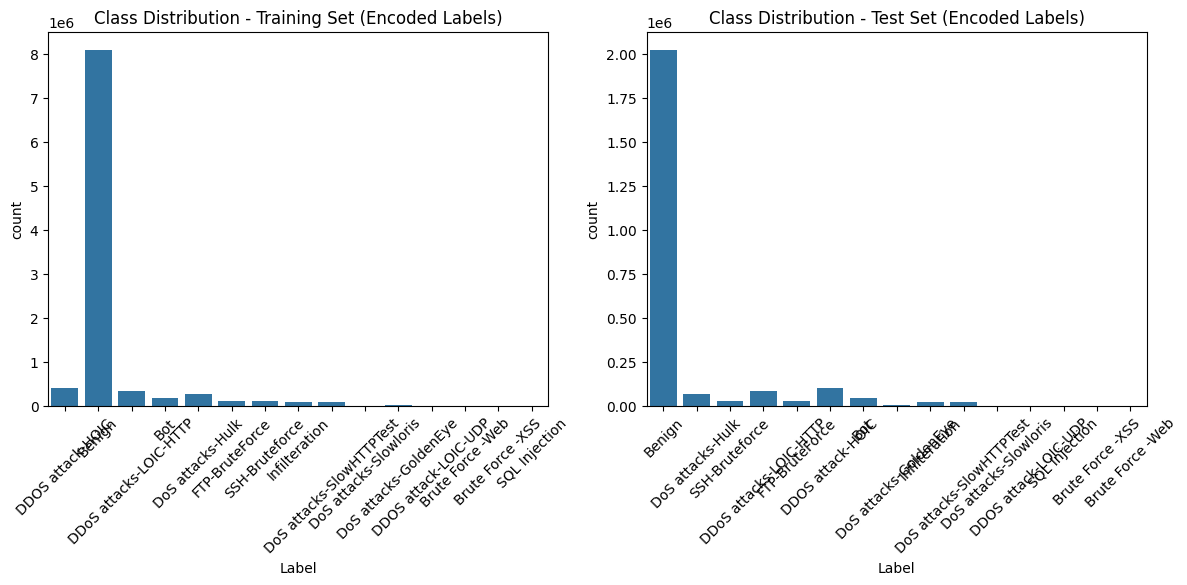

In [27]:
# Correct approach:
plt.figure(figsize=(12, 10))

# Plot 1: Training set class distribution (original labels)
plt.subplot(2, 2, 1)
sns.countplot(x=y_train)  # Using encoded labels directly
plt.title('Class Distribution - Training Set (Encoded Labels)')
plt.xticks(rotation=45)

# Plot 2: Test set class distribution (original labels)
plt.subplot(2, 2, 2)
sns.countplot(x=y_test)  # Using encoded labels directly
plt.title('Class Distribution - Test Set (Encoded Labels)')
plt.xticks(rotation=45)



plt.tight_layout()
plt.show()

76092/76092 ━━━━━━━━━━━━━━━━━━━━ 66s 863us/step


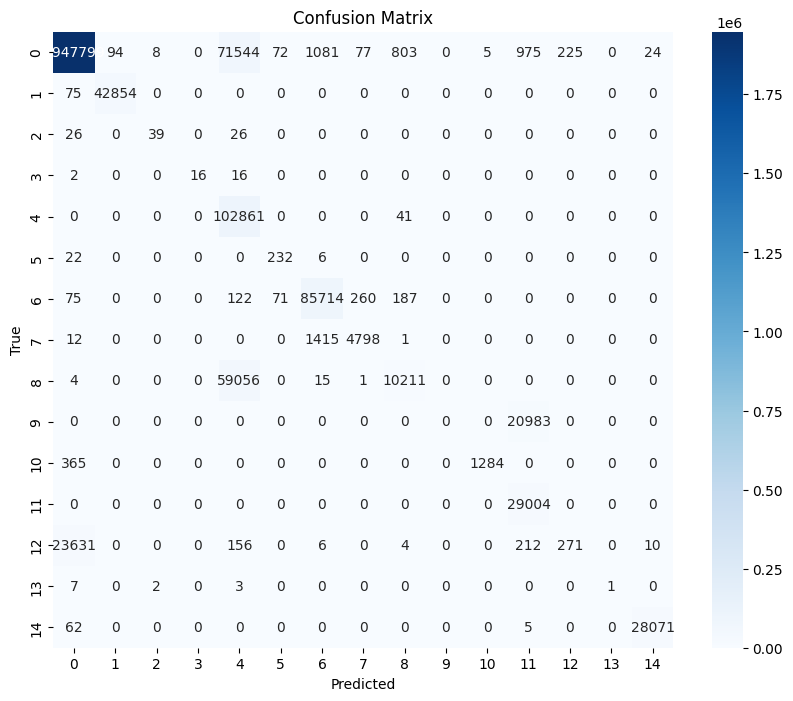

In [21]:
y_pred = np.argmax(model.predict(x_test_scaled), axis=1)
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [22]:
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

Classification Report:


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                          precision    recall  f1-score   support

                  Benign       0.99      0.96      0.98   2022707
                     Bot       1.00      1.00      1.00     42929
        Brute Force -Web       0.80      0.43      0.56        91
        Brute Force -XSS       1.00      0.47      0.64        34
        DDOS attack-HOIC       0.44      1.00      0.61    102902
    DDOS attack-LOIC-UDP       0.62      0.89      0.73       260
  DDoS attacks-LOIC-HTTP       0.97      0.99      0.98     86429
   DoS attacks-GoldenEye       0.93      0.77      0.84      6226
        DoS attacks-Hulk       0.91      0.15      0.25     69287
DoS attacks-SlowHTTPTest       0.00      0.00      0.00     20983
   DoS attacks-Slowloris       1.00      0.78      0.87      1649
          FTP-BruteForce       0.57      1.00      0.72     29004
           Infilteration       0.55      0.01      0.02     24290
           SQL Injection       1.00      0.08      0.14        13
         

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
np.save('scaler_mean.npy', scaler.mean_)
np.save('scaler_scale.npy', scaler.scale_)
np.save('label_encoder_classes.npy', le.classes_)